# AI Generated Privacy
This project is meant to investigate the ability of LLMs to extract data privacy practices from mobile app code sources.

This purpose of this notebook is to store the analysis of the project for review and reproducibility.

### Import Libraries for Analysis

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

### Import Data

In [2]:
# Import list of all possible data privacy practices
with open('dpps.csv', 'r') as file:
    dpps_categories = pd.read_csv(file)
    dpps = dpps_categories["Permission"].to_list()
    
# Import both human and ai generated data privacy practice datasets
with open('dpp_human_gen.json', 'r') as file_human, open('dpp_ai_gen.json', 'r') as file_ai:
    apps_dpp_human = json.load(file_human)
    apps_dpp_ai = json.load(file_ai)


In [3]:
len(apps_dpp_ai)
print(type(dpps))

<class 'list'>


### Check

In [4]:
for app in apps_dpp_human:
    diff = set(apps_dpp_human[app]).difference(dpps)
    if(len(diff) != 0):
       print(f"The app {app} has an element not in dpps: {diff}")
    
for app in apps_dpp_ai:
    diff = set(apps_dpp_ai[app]).difference(dpps)
    if(len(diff) != 0):
       print(f"The app {app} has an element not in dpps: {diff}")


## Calculate Precision and Recall

In [5]:
precis = []
recall = []
f1_scr = []
dpp_true_all = []
dpp_pred_all = []
# Go through each app
for app in apps_dpp_ai:
    dpp_true = []
    dpp_pred = []
    # Go through each dpp
    for dpp in dpps:
        # 1 if the dpp is truly used in the app, 0 if not
        dpp_true.append(dpp in apps_dpp_human[app])
        # 1 if the ai predicted the app used the dpp, 0 if not
        dpp_pred.append(dpp in apps_dpp_ai[app])
        
    
    # Get the precision and recall scores for the ai with this app
    precis.append(precision_score(dpp_true, dpp_pred, average='binary'))
    recall.append(recall_score(dpp_true, dpp_pred, average='binary'))
    f1_scr.append(f1_score(dpp_true, dpp_pred, average='binary'))
    dpp_true_all.extend(dpp_true)
    dpp_pred_all.extend(dpp_pred)

print(f"Precision Score: {np.mean(precis)}")
print(f"Recall Score: {np.mean(recall)}")
print(f"F1 Score: {np.mean(f1_scr)}")
print(f"Precision Score Overall: {precision_score(dpp_true_all, dpp_pred_all)}")
print(f"Recall Score Overall: {recall_score(dpp_true_all, dpp_pred_all)}")
print(f"F1 Score Overall: {f1_score(dpp_true_all, dpp_pred_all)}")

Precision Score: 0.37304354586540867
Recall Score: 0.35678225541228636
F1 Score: 0.30917027729262864
Precision Score Overall: 0.3363431151241535
Recall Score Overall: 0.36609336609336607
F1 Score Overall: 0.3505882352941176


/home/peanutbear/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Confusion Matrix
con_matrix = confusion_matrix(dpp_true_all, dpp_pred_all).transpose()
print(con_matrix)

[[2605  258]
 [ 294  149]]


In [7]:
from scipy.stats import t

# Calculate CI for each score
precis = np.array(precis)
precis_moe = t.ppf(.975, len(precis) - 1, loc=np.mean(precis))

print(precis_moe)
print(len(precis))

2.399236008894518
38


# Research Question 1
How accurately and completely can an LLM extract data practices directly from source code?

## Graph Results

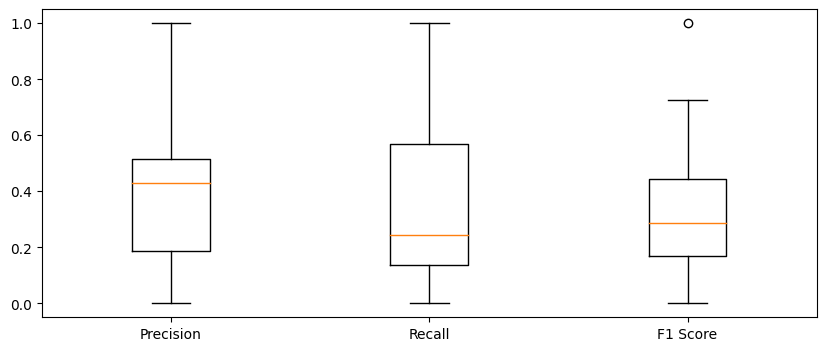

In [8]:
# Import libraries
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 4))

# Creating plot
plt.boxplot([precis, recall, f1_scr], labels=['Precision', 'Recall', "F1 Score"])
 
# show plot
plt.show()

In [10]:
print(np.median(recall))

0.24404761904761904


[Text(0.5, 23.52222222222222, 'True Value'),
 Text(50.72222222222221, 0.5, 'Predicted Value')]

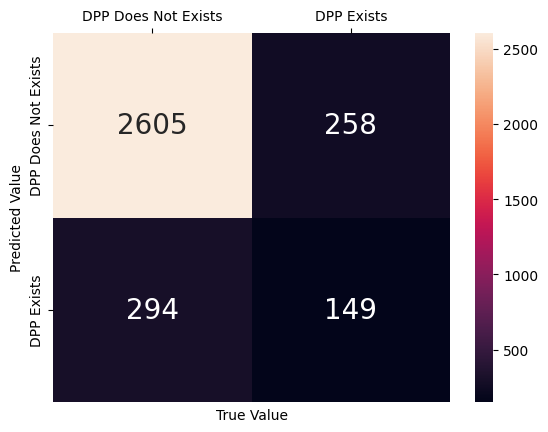

In [11]:
# Graph Confusion Matrix
import seaborn as sn

df_cm = pd.DataFrame(con_matrix, index = ["DPP Does Not Exists", "DPP Exists"],
                  columns = ["DPP Does Not Exists", "DPP Exists"])

ax = sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"fontsize":20})


ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
ax.set(xlabel="True Value", ylabel="Predicted Value")


# Research Question 2
Do the types of data practices used within an app have an differing effects on the effectiveness of an LLM to extract data practices?

In [11]:
# Create an empty DataFrame with specified columns
results = pd.DataFrame(columns=['Category', "App", 'F1Score'])

categories = list(set(dpps_categories["Category"]))

In [15]:
f1_scr_category = []
dpp_true_all = []
dpp_pred_all = []
# Go through each Data Privacy Category
for category in categories:
    # Focus the Permissions to just those of the Category
    dpps = list(dpps_categories["Permission"][dpps_categories["Category"] == category])
    
    # Go through each app
    for app in apps_dpp_ai:
        dpp_true = []
        dpp_pred = []
        
        # Go through each dpp
        for dpp in dpps:
            # 1 if the dpp is truly used in the app, 0 if not
            dpp_true.append(dpp in apps_dpp_human[app])
            # 1 if the ai predicted the app used the dpp, 0 if not
            dpp_pred.append(dpp in apps_dpp_ai[app])

        # Only get a score if there was at least one 
        #     permission for the category in the app
        if sum(dpp_true):
            f1 = f1_score(dpp_true, dpp_pred, average='binary')
            # Add the f1 score to the table
            row = pd.DataFrame([{"Category": category, "App": app, "F1Score": f1}])
            results = pd.concat([results, row], ignore_index=True)

print(results)

     Category                                App   F1Score
0       Other                  com.standardnotes  0.750000
1       Other          com.automattic.simplenote  0.421053
2       Other                  de.ph1b.audiobook  0.000000
3       Other       de.reimardoeffinger.quickdic  0.666667
4       Other                      org.xbmc.kodi  0.500000
..        ...                                ...       ...
160  Contacts         org.thoughtcrime.securesms  0.500000
161  Contacts               com.nextcloud.client  0.500000
162  Contacts            com.mapswithme.maps.pro  1.000000
163  Contacts                     com.moez.QKSMS  0.666667
164  Contacts  com.menny.android.anysoftkeyboard  0.666667

[165 rows x 3 columns]


# Graph Results
Estimate of average of F1 scores with error bars

In [23]:
# Massage Data
plot_list = []
for category in set(list(results["Category"])):
    l = list(results['F1Score'][results["Category"] == category])
    plot_list.append(np.mean(l))